# Visualizing the CMC ranking
Before using this notebook it is expected that models are trained and embeddings are created using the 'main_implementation.ipynb' notebook

## Set-up
first, import packages

In [0]:
# import packages
import h5py
import os
import pandas as pd
from google.colab import drive
import cv2
import datetime as dt
from PIL import Image
import numpy as np
import sys
import logging
import time
import itertools
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import pickle
from tqdm import tqdm

In [0]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive/Thesis re-id/triplet-reid-master")

In [0]:
# Loading local classes and functions
from own_code.backbone_normal import EmbedNetwork
from own_code.loss import TripletLoss
from own_code.triplet_selector import BatchHardTripletSelector
from own_code.batch_sampler import BatchSampler
from own_code.Market1501 import Market1501
from own_code.optimizer import AdamOptimWrapper
#import the anti-aliased networks
from models_lpf import *
import models_lpf.resnet

## Evaluation function

In [0]:
from utils import pdist_np as pdist


In [0]:
def evaluate(test_embs, query_embs, cmc_rank):
    ## logging
    FORMAT = '%(levelname)s %(filename)s:%(lineno)d: %(message)s'
    logging.basicConfig(level=logging.INFO, format=FORMAT, stream=sys.stdout)
    logger = logging.getLogger(__name__)

    ## load embeddings
    logger.info('loading gallery embeddings')
    with open(test_embs, 'rb') as fr:
        gallery_dict = pickle.load(fr)
        emb_gallery, lb_ids_gallery, lb_cams_gallery = gallery_dict['embeddings'], gallery_dict['label_ids'], gallery_dict['label_cams']
    logger.info('loading query embeddings')
    with open(query_embs, 'rb') as fr:
        query_dict = pickle.load(fr)
        emb_query, lb_ids_query, lb_cams_query = query_dict['embeddings'], query_dict['label_ids'], query_dict['label_cams']

    ## compute and clean distance matrix
    dist_mtx = pdist(emb_query, emb_gallery)
    n_q, n_g = dist_mtx.shape
    indices = np.argsort(dist_mtx, axis = 1)
    matches = lb_ids_gallery[indices] == lb_ids_query[:, np.newaxis]
    matches = matches.astype(np.int32)
    all_aps = []
    all_cmcs = []
    logger.info('starting evaluating ...')
    for qidx in tqdm(range(n_q)):
        qpid = lb_ids_query[qidx]
        qcam = lb_cams_query[qidx]

        order = indices[qidx]
        pid_diff = lb_ids_gallery[order] != qpid
        cam_diff = lb_cams_gallery[order] != qcam
        useful = lb_ids_gallery[order] != -1
        keep = np.logical_or(pid_diff, cam_diff)
        keep = np.logical_and(keep, useful)
        match = matches[qidx][keep]

        if not np.any(match): continue

        cmc = match.cumsum()
        cmc[cmc > 1] = 1
        all_cmcs.append(cmc[:cmc_rank])

        num_real = match.sum()
        match_cum = match.cumsum()
        match_cum = [el / (1.0 + i) for i, el in enumerate(match_cum)]
        match_cum = np.array(match_cum) * match
        ap = match_cum.sum() / num_real
        all_aps.append(ap)

    assert len(all_aps) > 0, "NO QUERY MATCHED"
    mAP = sum(all_aps) / len(all_aps)
    all_cmcs = np.array(all_cmcs, dtype = np.float32)
    cmc = np.mean(all_cmcs, axis = 0)

    print('mAP is: {}, cmc is: {}'.format(mAP, cmc))
    return(cmc)

## Visualize CMC

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

default_color = ['r','g','b','c','m','y','orange','brown']
default_marker = ['*','o','s','v','X','*','.','P']

class CMC:
    def __init__(self,cmc_dict, color=default_color, marker = default_marker):
        self.color = color
        self.marker = marker
        self.cmc_dict = cmc_dict
        
    def plot(self,title,rank=20, xlabel='Rank',ylabel='Matching Rates (%)',show_grid=True):        
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(0, rank+1, 5))
        plt.ylim(0.86, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))
                
            if name == list(self.cmc_dict.keys())[-1]:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[0], marker=self.marker[0], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i+1], marker=self.marker[i+1], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        plt.show()
    
    def save(self, title, filename, 
             rank=20, xlabel='Rank',
             ylabel='Matching Rates (%)', show_grid=True,
             save_path=os.getcwd(), format='png', **kwargs):
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(0, rank+1, 5))
        plt.ylim(0.86, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))
                
            if name == list(self.cmc_dict.keys())[-1]:
                globals()[name] = mlines.Line2D(r, temp_cmc, color='r', marker='*', label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i], marker=self.marker[i], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        fig.savefig(os.path.join(save_path,filename+'.'+format), 
                    format=format,
                    bbox_inches='tight',
                    pad_inches = 0, **kwargs)

In [0]:
def all_cmcs(model_num, cmc_rank = 20):
  test_embs = "./res/emb_test{}.pkl".format(model_num)
  query_embs = "./res/emb_query{}.pkl".format(model_num)
  model_ranks = evaluate(test_embs = test_embs, query_embs = query_embs, cmc_rank = cmc_rank)

  return(model_ranks)


In [0]:
model1_ranks = all_cmcs(model_num = 1)
model6_ranks = all_cmcs(model_num = 6)
model7_ranks = all_cmcs(model_num = 7)
model8_ranks = all_cmcs(model_num = 8)

100%|██████████| 3368/3368 [01:52<00:00, 30.33it/s]


mAP is: 0.7632220459713979, cmc is: [0.88925177 0.9248812  0.9450713  0.9554632  0.96169835 0.966152
 0.9682304  0.9700119  0.9726841  0.9750594  0.97684085 0.9783254
 0.9801069  0.98070073 0.9809976  0.9809976  0.98218524 0.9833729
 0.9833729  0.98396677]


100%|██████████| 3368/3368 [01:52<00:00, 28.67it/s]


mAP is: 0.7507753063839253, cmc is: [0.88182896 0.9162708  0.9334917  0.9435867  0.95190024 0.95961994
 0.962886   0.9649644  0.9703088  0.9711995  0.9723872  0.9750594
 0.97654396 0.9774347  0.9783254  0.97981    0.9804038  0.9809976
 0.9812945  0.98218524]


100%|██████████| 3368/3368 [01:53<00:00, 29.76it/s]


mAP is: 0.7513740780773932, cmc is: [0.8871734  0.9236936  0.93705463 0.94804037 0.956057   0.96169835
 0.9664489  0.96941805 0.97149646 0.9735748  0.976247   0.9774347
 0.97981    0.9812945  0.9812945  0.98218524 0.9824822  0.9824822
 0.9833729  0.98426366]


100%|██████████| 3368/3368 [01:51<00:00, 30.08it/s]


mAP is: 0.7417072430419447, cmc is: [0.8738124  0.91270787 0.9376485  0.9483373  0.9578385  0.96229213
 0.9655582  0.9682304  0.9709026  0.9732779  0.97416866 0.97654396
 0.9774347  0.9786223  0.97981    0.98070073 0.9812945  0.98159146
 0.98218524 0.98307604]


In [0]:
model1_ranks = list(model1_ranks)
model6_ranks = list(model6_ranks)
model7_ranks = list(model7_ranks)
model8_ranks = list(model8_ranks)

In [0]:
cmc_dict = {'Baseline': model1_ranks, 'Filter size 2': model7_ranks, "Filter size 3": model6_ranks, "Filter size 5": model8_ranks}
new_color = ['r','g','b','c','m','y','orange','brown']
new_marker = ['*','o','s','v','X','*','.','P']
cmc = CMC(cmc_dict,color=new_color,marker=new_marker)

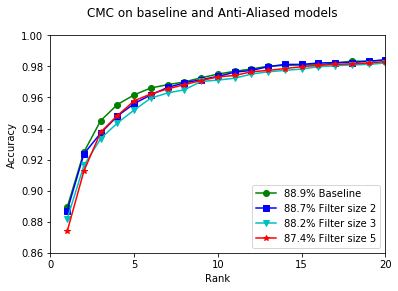

In [0]:
cmc.plot(title = "CMC on baseline and Anti-Aliased models", ylabel= "Accuracy", show_grid = False)


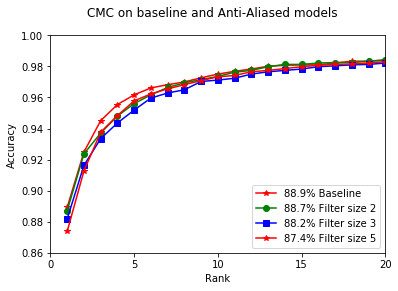

In [0]:
cmc.save(title = 'CMC on baseline and Anti-Aliased models', filename='cmc_results',
         rank=20,xlabel='Rank', ylabel='Accuracy', 
         show_grid=False, format='png')